---
---
---
# <span style="color:orange">__Michael Evan__</span>
---
- Student #: 02081213
- mevan@umassd.edu
- CIS602 Fundamentsls of Deep Learning: Project 3 RNNs
- University of Massachussetts Dartmouth
- Graduate Computer Science Department
- Fall 2025
- Due: 11/25/2025
---
# <span style="color:orange">__Deep Learning & Audio Word Recognition__</span>
---
## <span style="color:orange">__Utilize PyTorch GRU & LSTM RNNs__</span>
---
### <span style="color:orange">__Train and run inference for audio word prediction__</span>
- Dataset directory of individual words in respective directories
- 80/10/10 unique train/val/test sets created preserving orginal dataset
- Live Python inference script also available for real-time voice (word) recognition accuracy
#### <span style="color:orange">__Audio source files created by: Pete Warden of Google Brain - Mountain View California__</span>
- <span style="color:orange">Original dataset 3.43GB of 35 words - 105,829 utterances</span>
- <span style="color:orange">Words stored: mono ~33 KB .wav file: 16kHz sample rate - 16 Bits per sample</span>
- <span style="color:orange">12 words utilized for the project: <span style="color:yellow">(yes,no,bird,cat,dog,up,down,left,right,stop,go,forward)</span>
- <span style="color:orange">training set: 1GB, validation set: 194MB, test set: 194MB</span>
#### <span style="color:orange">__Note: M1 mac requires approx: 1 hour to complete entire notebook__</span>
#### <span style="color:orange">__Source file direct download:__</span> http://download.tensorflow.org/data/speech_commands_v0.02.tar.gz
#### <span style="color:orange">__Dataset research paper:__</span> https://arxiv.org/abs/1804.03209

---
---
---

In [1]:

import sys, os, warnings
print("Python exec:", sys.executable)
print("Python version:", sys.version.splitlines()[0])
%pip install --upgrade pip

%pip install datasets soundfile librosa numpy matplotlib scikit-learn seaborn
# CPU-only wheel index (works on most macOS systems)
%pip install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cpu


Python exec: /Users/michaelevan/Universities/UMass/DeepLearning/Week_10/venv/bin/python3.11
Python version: 3.11.13 (main, Jun  3 2025, 18:38:25) [Clang 17.0.0 (clang-1700.0.13.3)]
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cpu
Note: you may need to restart the kernel to use updated packages.


In [ ]:
warnings.filterwarnings("ignore")

- <span style="color:orange">__My Imports & Sanity Check__</span>

In [3]:
import importlib, sys, numpy, random, shutil, csv
import pandas as pd
import matplotlib.pyplot as plt
import seaborn
import torch
import torch.nn as nn
import torchaudio
import soundfile
import librosa
from collections import defaultdict
for p in ("datasets","soundfile","librosa","torch","torchaudio", "os", "sys", "numpy", "matplotlib", "pandas", "seaborn", "random", "shutil", "csv", "collections"):
    try:
        importlib.import_module(p)
        print(p, "---> Ok ...😎")
    except Exception as e:
        print(p, " Import Error!!!...🔥🔥🔥", e)
print("Python exec:", sys.executable)

datasets ---> Ok ...😎
soundfile ---> Ok ...😎
librosa ---> Ok ...😎
torch ---> Ok ...😎
torchaudio ---> Ok ...😎
os ---> Ok ...😎
sys ---> Ok ...😎
numpy ---> Ok ...😎
matplotlib ---> Ok ...😎
pandas ---> Ok ...😎
seaborn ---> Ok ...😎
random ---> Ok ...😎
shutil ---> Ok ...😎
csv ---> Ok ...😎
collections ---> Ok ...😎
Python exec: /Users/michaelevan/Universities/UMass/DeepLearning/Week_10/venv/bin/python3.11


- ### <span style="color:orange">__Create output directory "clips" if missing__</span>
- ### <span style="color:orange">__Split audio files__</span>
- <span style="color:orange">__Note: Original developers train/val/test recommendation not utilized__</span>
- <span style="color:orange">__Keep speakers disjoint and aims for ~ 80/10/10 per class__</span>
- <span style="color:orange">__Scans `extracted_speech_commands` directory for TARGETS__</span>
- <span style="color:orange">__Builds speaker: train/val/test assignments__</span>
- <span style="color:orange">__Creates OUTDIR `my_out_dir` and subfolders: `/train/clips`, `/val/clips`, `/test/clips` (mkdir if missing)__</span>
- <span style="color:orange">__Copies selected files into those clips folders, renaming each to: label__originalname.__</span>
- <span style="color:orange">__Builds and writes `clips.tsv` with (relative path, sentence, split)__</span>

In [ ]:
import os, random, shutil, csv
from collections import defaultdict, Counter

''' ***** Must edit these paths/settings as needed for your system/setup ***** '''
SRC = "/Users/michaelevan/Universities/UMass/DeepLearning/Week_10/extracted_speech_commands"    # source directory
OUTDIR = "/Users/michaelevan/Universities/UMass/DeepLearning/Week_10/my_out_dir"                # output directory
''' ***** end editable paths/settings ***** '''

TARGETS = ["yes","no","bird","cat","dog","up","down","left","right","stop","go","forward"]      # target labels
N_PER_CLASS = 0                     # per-class cap per split (0 = disables split cap)
SEED = 42                           # random seed for reproducibility
SPLIT = (0.8, 0.1, 0.1)             # train,val,test
SPLITS = ("train","val","test")     # dataset splits

random.seed(SEED)                   # set random seed for reproducibility
os.makedirs(OUTDIR, exist_ok=True)  # create output directory if it doesn't exist

''' gather files per speaker & per label '''
speaker_files = defaultdict(lambda: defaultdict(list))  # initialize nested dictionary for speaker files
labels = sorted(set(TARGETS))                           # get sorted list of unique target labels
for label in labels:                                    # iterate over labels
    folder = os.path.join(SRC, label)                   # get folder path for label
    if not os.path.isdir(folder):                       # check if folder exists
        print("Missing folder:", folder)                # print missing folder message
        continue                                        # skip missing folders
    for fn in sorted(os.listdir(folder)):               # iterate over files in folder
        if not fn.lower().endswith((".wav", ".mp3")): continue          # .wav or .mp3 ok : skip non-audio files
        speaker = fn.split('_')[0]                                      # extract speaker ID from filename
        speaker_files[speaker][label].append(os.path.join(folder, fn))  # add file path to speaker's label list

''' compute quotas per label based on SPLIT ratios '''
total_per_label = {l: sum(len(speaker_files[s][l]) for s in speaker_files) for l in labels} # calculate total files per label
quotas = {}                         # initialize quotas dictionary
for l in labels:                    # iterate over labels
    n = total_per_label.get(l, 0)   # get total number of files for label
    n_train = int(n * SPLIT[0])     # calculate number of training samples
    n_val = int(n * SPLIT[1])       # calculate number of validation samples
    n_test = n - n_train - n_val    # calculate number of test samples
    quotas[l] = {"train": n_train, "val": n_val, "test": n_test}    # store quotas for label

''' assign speakers to splits '''
speakers = list(speaker_files.keys())   # get list of speakers
random.shuffle(speakers)                # shuffle speakers randomly
assigned = {}                           # dictionary to hold speaker assignments
assigned_counts = {l: {"train":0,"val":0,"test":0} for l in labels}  # initialize assigned counts

for sp in speakers:  # iterate over speakers
    contrib = {l: len(speaker_files[sp].get(l, [])) for l in labels}    # get contribution of files per label for speaker
    best_split, best_fit, best_overflow = None, -1, None                # initialize best split variables
    for split in SPLITS:                # iterate over splits
        fit = 0; overflow = 0           # initialize fit and overflow counters
        for l in labels:                # iterate over labels
            rem = max(0, quotas[l][split] - assigned_counts[l][split])  # remaining quota for label in split
            if contrib[l] <= rem:       # fits within remaining quota
                fit += contrib[l]       # add contribution to fit
            else:                       # exceeds remaining quota
                fit += max(0, rem)      # add remaining quota to fit
                overflow += contrib[l] - max(0, rem)                    # add overflow amount
        if (fit > best_fit) or (fit == best_fit and (best_overflow is None or overflow < best_overflow)) or (fit==best_fit and overflow==best_overflow and split=="train"):
            best_split, best_fit, best_overflow = split, fit, overflow  # update best split variables
    assigned[sp] = best_split           # assign best split to speaker
    for l in labels:    
        assigned_counts[l][best_split] += contrib[l]        # update assigned counts

# collect files per split & per class (from assigned speakers)
split_items = {s: defaultdict(list) for s in SPLITS}        # initialize split items dictionary
for sp, split in assigned.items():                          # iterate over assigned speakers
    for l in labels:                                        # iterate over labels
        for p in speaker_files[sp].get(l, []):              # iterate over files for label
            split_items[split][l].append(p)                 # append file to split items

'''
- Where the magic happens: folder names of word appended to individual .wav files
- loop copies chosen files into OUTDIR//clips
- renames each copy to label__originalfilename (label is the class from the folder/TARGETS)
- appends a row (relative_path, label, split) into clips.tsv.
- originals in SRC are untouched!
- skips copying if the target file already exists (no overwrite)
'''
final_rows = []         # list to hold final rows for TSV
for split in SPLITS:    # iterate over each split
    out_clips = os.path.join(OUTDIR, split, "clips")        # output directory for clips
    os.makedirs(out_clips, exist_ok=True)                   # create directory if it doesn't exist
    for l in labels:
        items = split_items[split].get(l, [])               # get items for label in split
        target = quotas[l][split] if quotas[l][split] > 0 else len(items)   # target number of items for label in split
        if N_PER_CLASS and N_PER_CLASS > 0:                 # apply per-class cap if set
            target = min(target, N_PER_CLASS)               # cap target to N_PER_CLASS
        if len(items) > target:                             # sample if more than target   
            items = random.sample(items, target)            # sample items
        for src in items:                                   # copy each sampled item
            base = os.path.basename(src)                    # get base filename
            out_name = f"{l}__{base}"                       # create output filename
            out_path = os.path.join(out_clips, out_name)    # full output path
            if not os.path.exists(out_path):                # copy file if it doesn't already exist
                shutil.copy2(src, out_path)                 # copy file
            rel = os.path.join(split, "clips", out_name)    # relative path for TSV
            final_rows.append((rel, l, split))              # append final row

''' write clips.tsv '''
tsv_path = os.path.join(OUTDIR, "clips.tsv")
with open(tsv_path, "w", encoding="utf-8", newline="") as f:    # open TSV file for writing
    w = csv.writer(f, delimiter="\t")                           # create CSV writer
    w.writerow(["path","sentence","split"])                     # write header row
    for r in final_rows:                                        # write each row loop
        w.writerow(r)                                           # write row

# summary output
print("Summary:"), print()
print("Quotas = target counts computed from total files x (80/10/10) split.)")
print("Actual = actually assigned and copied to train/val/test & speaker-unique splits, sampling caps.")
print()

# aligned summary printout
print(f"{'label':<10} {'total':>7}   {'Quotas: train -  val - test':>25}   {'Actual: train -  val - test':>25}")
print()
for l in labels:                    # iterate over each label
    tot = total_per_label.get(l,0)  # total samples for label
    q = quotas[l]                   # quotas for label
    actual = (sum(1 for r in final_rows if r[1]==l and r[2]=="train"),  # actual samples for label
              sum(1 for r in final_rows if r[1]==l and r[2]=="val"),    # actual samples for label
              sum(1 for r in final_rows if r[1]==l and r[2]=="test"))   # actual samples for label
    print(f"{l:<10} {tot:7d}           {q['train']:5d} -{q['val']:5d} -{q['test']:5d}           {actual[0]:5d} -{actual[1]:5d} -{actual[2]:5d}")
print()
print("Wrote TSV:", tsv_path)       # print output path

Summary:

Quotas = target counts computed from total files x (80/10/10) split.)
Actual = actually assigned and copied to train/val/test & speaker-unique splits, sampling caps.

label        total   Quotas: train -  val - test   Actual: train -  val - test

bird          2064            1651 -  206 -  207            1641 -  206 -  207
cat           2031            1624 -  203 -  204            1624 -  203 -  198
dog           2128            1702 -  212 -  214            1702 -  209 -  209
down          3917            3133 -  391 -  393            3133 -  391 -  386
forward       1557            1245 -  155 -  157            1237 -  155 -  157
go            3880            3104 -  388 -  388            3104 -  384 -  388
left          3801            3040 -  380 -  381            3040 -  380 -  379
no            3941            3152 -  394 -  395            3152 -  377 -  395
right         3778            3022 -  377 -  379            3022 -  377 -  365
stop          3872            30

# <span style="color:orange">__Data Loader__</span>

In [5]:
# minimal dataloader
import glob, numpy as np, soundfile as sf, librosa, torch
from torch.utils.data import Dataset, DataLoader

''' ***** output directory (must match previous OUTDIR) ***** '''
OUTDIR = "/Users/michaelevan/Universities/UMass/DeepLearning/Week_10/my_out_dir"   # output directory (must match previous OUTDIR)

SR = 16000; N_MELS = 40; WIN = 400; HOP = 160; FRAMES = 100     # number of frames in the spectrogram
BATCH = 64  # batch size

def list_split(split):                              # list files in split
    p = os.path.join(OUTDIR, split, "clips", "*")   # path to audio files in split
    return sorted([os.path.basename(x) for x in glob.glob(p) if x.lower().endswith((".wav",".mp3"))])   # list of audio files

# build label set from filenames (label before "__")
labels = set()                      # set to hold unique labels
for s in ("train","val","test"):    # iterate over splits
    for fn in list_split(s):        # iterate over files in split
        lbl = fn.split("__")[0]     # extract label from filename
        labels.add(lbl)             # add label to set
labels = sorted(labels)             # sort labels
label2idx = {l:i for i,l in enumerate(labels)}  # map labels to indices
print("Labels:", labels)            # print labels

def rows_from_split(split):         # get rows for split
    out = []                        # list to hold rows
    base = os.path.join(OUTDIR, split, "clips")   # base directory for clips
    for fn in list_split(split):                  # iterate over files in split
        out.append((os.path.join(split, "clips", fn), fn.split("__")[0], base)) # append file info to list
    return out                      # return list of rows

class SC_Dataset(Dataset):          # Speech Commands Dataset
    def __init__(self, rows):       # initialize dataset with rows
        self.rows = rows            # list of data rows
        
    def __len__(self): return len(self.rows)
    
    ''' mel spectrogram '''
    def _wav_to_logmels(self, full_path):   
        y, sr = sf.read(full_path)          # read audio file
        if y.ndim>1: y = y.mean(axis=1)     # convert to mono
        if sr != SR: y = librosa.resample(y.astype(np.float32), orig_sr=sr, target_sr=SR)   # resample if needed
        S = librosa.feature.melspectrogram(y=y, sr=SR, n_fft=WIN, hop_length=HOP, n_mels=N_MELS, power=2.0)   # compute mel spectrogram
        S_db = librosa.power_to_db(S, ref=np.max).T     # convert to log scale and transpose
        if S_db.shape[0] < FRAMES:                      # pad if too short
            pad = np.zeros((FRAMES - S_db.shape[0], N_MELS), dtype=S_db.dtype); S_db = np.vstack([S_db, pad])   # pad with zeros
        else:                                           # truncate if too long
            S_db = S_db[:FRAMES, :]
        S_db = (S_db - S_db.mean()) / (S_db.std() + 1e-6)   # normalize
        return S_db.astype(np.float32)                      # return normalized log-mel spectrogram
    
    def __getitem__(self, i):
        relpath, lbl, base = self.rows[i]                   # get relative path, label, and base directory
        full = os.path.join(OUTDIR, relpath)                # get full path to audio file
        feats = self._wav_to_logmels(full)                  # extract features
        return torch.from_numpy(feats), label2idx[lbl]      # return features and label index

train_rows = [(os.path.join(OUTDIR, s, "clips", fn), fn.split("__")[0], os.path.join(OUTDIR, s, "clips")) for s in ("train",) for fn in list_split("train")]    # list of training data rows
val_rows   = [(os.path.join(OUTDIR, s, "clips", fn), fn.split("__")[0], os.path.join(OUTDIR, s, "clips")) for s in ("val",)   for fn in list_split("val")]      # list of validation data rows
test_rows  = [(os.path.join(OUTDIR, s, "clips", fn), fn.split("__")[0], os.path.join(OUTDIR, s, "clips")) for s in ("test",)  for fn in list_split("test")]     # list of test data rows

train_ds = SC_Dataset(train_rows)   # create training dataset
val_ds   = SC_Dataset(val_rows)     # create validation dataset
test_ds  = SC_Dataset(test_rows)    # create test dataset

train_loader = DataLoader(train_ds, batch_size=BATCH, shuffle=True, num_workers=0)  # create training data loader
val_loader   = DataLoader(val_ds,   batch_size=BATCH, shuffle=False, num_workers=0) # create validation data loader
test_loader  = DataLoader(test_ds,  batch_size=BATCH, shuffle=False, num_workers=0) # create test data loader

bx, by = next(iter(train_loader))   # get a batch of training data
print("batch_x shape:", bx.shape, "batch_y shape:", by.shape, "num classes:", len(labels))  # print batch shapes and number of classes

Labels: ['bird', 'cat', 'dog', 'down', 'forward', 'go', 'left', 'no', 'right', 'stop', 'up', 'yes']
batch_x shape: torch.Size([64, 100, 40]) batch_y shape: torch.Size([64]) num classes: 12


# - <span style="color:orange">__GRU-based classifier__</span>

In [ ]:
''' define GRU model '''
class RNNClassifierGRU(nn.Module):
    
    def __init__(self, input_size, hidden_size, num_layers, num_classes, bidirectional=False, dropout=0.0):
        super().__init__()                                      # initialize the base class
        self.rnn = nn.GRU(input_size, hidden_size, num_layers,  # initialize GRU layer
                          batch_first=True, bidirectional=bidirectional, dropout=dropout)
        self.num_directions = 2 if bidirectional else 1         # number of directions
        self.fc = nn.Linear(hidden_size * self.num_directions, num_classes)  # fully connected layer
        
    def forward(self, x):
        out, _ = self.rnn(x)        # (batch, seq, hidden*dirs)
        out = out[:, -1, :]         # last timestep
        return self.fc(out)         # fully connected layer

# device
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")  # set device to MPS if available, else CPU
print("Device:", device)    # print device

''' instantiate model (match feature dims) '''
model = RNNClassifierGRU(input_size=40, hidden_size=128, num_layers=2, num_classes=12)  #
model.to(device)    # move model to device
print("Params:", sum(p.numel() for p in model.parameters() if p.requires_grad))  # print number of trainable parameters

# test forward with batch 'bx' (must be in memory from dataloader step)
out = model(bx.to(device))          # forward pass
print("Output shape:", out.shape)   # should be (batch_size, num_classes)

Device: mps
Params: 165900
Output shape: torch.Size([64, 12])



- <span style="color:orange">Learning Curve Plot</span>


In [7]:
def plot_learning_curves(train_losses, val_losses, title='Learning Curves', out=None, show=True):
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots(figsize=(7,4))
    epochs = range(1, len(train_losses) + 1)
    ax.plot(epochs, train_losses, label='train loss')
    ax.plot(epochs, val_losses, label='val loss')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss (MAE)')
    ax.set_title(title)
    ax.legend()
    ax.grid(alpha=0.3)
    fig.tight_layout()
    if out:
        fig.savefig(out, dpi=150)
    if show:
        plt.show()
    plt.close(fig)

# - <span style="color:orange">__GRU gated RNN model__</span>
- <span style="color:orange">__The `.wav` files are read and converted to mel spectrograms on the fly (librosa.melspectrogram) before being fed to the RNN.__</span>


Epoch 1/20 train_loss=1.1934 val_loss=0.4576 val_acc=85.94% time=90.8s
Saved best_gru.pt (epoch 1, val_acc=85.94%)
Epoch 2/20 train_loss=0.3900 val_loss=0.2727 val_acc=91.77% time=85.1s
Saved best_gru.pt (epoch 2, val_acc=91.77%)
Epoch 3/20 train_loss=0.2682 val_loss=0.2536 val_acc=91.85% time=85.1s
Saved best_gru.pt (epoch 3, val_acc=91.85%)
Epoch 4/20 train_loss=0.2087 val_loss=0.1996 val_acc=93.75% time=94.1s
Saved best_gru.pt (epoch 4, val_acc=93.75%)
Epoch 5/20 train_loss=0.1734 val_loss=0.1813 val_acc=94.27% time=99.5s
Saved best_gru.pt (epoch 5, val_acc=94.27%)
Epoch 6/20 train_loss=0.1487 val_loss=0.1826 val_acc=94.01% time=94.0s
Epoch 7/20 train_loss=0.1258 val_loss=0.1833 val_acc=94.06% time=86.4s
Epoch 8/20 train_loss=0.1145 val_loss=0.1576 val_acc=95.05% time=87.8s
Saved best_gru.pt (epoch 8, val_acc=95.05%)
Epoch 9/20 train_loss=0.0985 val_loss=0.1422 val_acc=95.57% time=86.2s
Saved best_gru.pt (epoch 9, val_acc=95.57%)
Epoch 10/20 train_loss=0.0870 val_loss=0.1712 val_acc

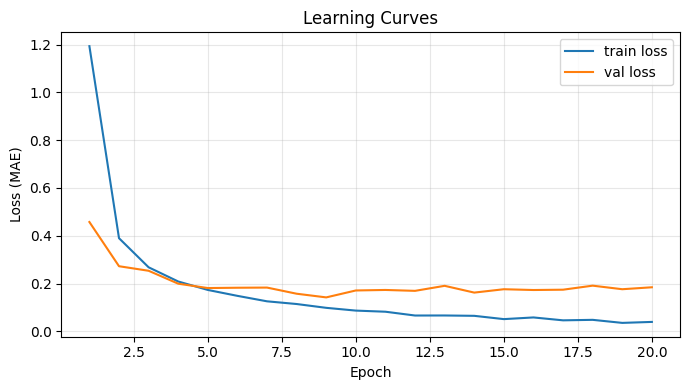

In [ ]:
import time

train_losses = []                                           # list to hold training losses
val_losses = []                                             # list to hold validation losses

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)   # Adam optimizer
loss_fn = torch.nn.CrossEntropyLoss()                       # cross-entropy loss
epochs = 20                                                 # number of epochs
best_val = -1.0                                             # best validation accuracy
no_improve = 0                                              # epochs since last improvement
patience = 10                                               # early stopping patience

''' training loop '''
for ep in range(1, epochs+1):
    t0 = time.time()                                        # start time
    model.train()                                           # set model to training mode
    running, seen = 0.0, 0                                  # initialize running loss and seen samples
    for x,y in train_loader:                                # iterate over training data
        x = x.to(device); y = y.to(device).long()           # move data to device               
        optimizer.zero_grad()                               # zero gradients
        out = model(x)                                      # forward pass
        loss = loss_fn(out, y)                              # compute loss
        loss.backward()                                     # backward pass
        optimizer.step()                                    # update weights
        running += loss.item() * x.size(0)                  # accumulate loss
        seen += x.size(0)                                   # accumulate seen samples
    train_loss = running / max(1, seen)                     # compute average training loss

    ''' validation (compute val_loss and val_acc) '''
    model.eval()                                            # set model to evaluation mode
    val_running, total, correct = 0.0, 0, 0                 # initialize validation metrics
    with torch.no_grad():                                   # disable gradient computation
        for x,y in val_loader:                              # iterate over validation data
            x = x.to(device); y = y.to(device).long()       # move data to device
            out = model(x)                                  # forward pass
            loss_v = loss_fn(out, y)                        # compute loss
            val_running += loss_v.item() * x.size(0)        # accumulate validation loss
            preds = out.argmax(dim=1)                       # get predictions
            correct += (preds == y).sum().item()            # count correct predictions
            total += y.size(0)                              # accumulate total samples
    val_loss = val_running / max(1, total)                  # compute average validation loss
    val_acc = 100.0 * correct / total if total>0 else 0.0   # compute validation accuracy

    print(f"Epoch {ep}/{epochs} train_loss={train_loss:.4f} val_loss={val_loss:.4f} val_acc={val_acc:.2f}% time={time.time()-t0:.1f}s")

    ''' save best '''
    if val_acc > best_val:                                  # check for improvement
        best_val = val_acc                                  # update best validation accuracy  
        no_improve = 0                                      # reset no improvement counter
        torch.save({
            "epoch": ep,
            "model_state": model.state_dict(),
            "optimizer_state": optimizer.state_dict(),
            "val_acc": val_acc,
            "labels": labels
        }, "best_gru.pt")                                   # save checkpoint
        print(f"Saved best_gru.pt (epoch {ep}, val_acc={val_acc:.2f}%)")
    else:
        no_improve += 1                                     # increment no improvement counter
        if patience and no_improve >= patience:             # check for early stopping
            print(f"No improvement for {patience} epochs — stopping at epoch {ep}")
            break

    train_losses.append(train_loss)                         # append training loss
    val_losses.append(val_loss)                             # append validation loss

# plot curves
plot_learning_curves(train_losses, val_losses, out="learning_curves.png", show=True)

### - <span style="color:orange">__GRU final test accuracy__</span>
#### - <span style="color:orange">__load best epoch & test__</span>


In [9]:
ck = torch.load("best_gru.pt", map_location=device)
model.load_state_dict(ck["model_state"])   
model.to(device).eval()                    
correct,total=0,0                          
with torch.no_grad():                    
    for x,y in test_loader:
        x = x.to(device); y = y.to(device)
        correct += (model(x).argmax(1)==y).sum().item()
        total += y.size(0)
        
val = ck.get("val_acc", "?")
test_acc = 100.0 * correct / total if total > 0 else 0.0
val_str = f"{val:.2f}%" if isinstance(val, (int, float)) else val
print()
print(f"Best val epoch {ck.get('epoch','?')} val_acc {val_str} Test acc {test_acc:.2f}%")


Best val epoch 17 val_acc 95.60% Test acc 94.64%


### - <span style="color:orange">__GRU confusion matrix & heatmap__</span>

Overall test acc: 0.946396

              precision    recall  f1-score   support

        bird       0.92      0.97      0.94       207
         cat       0.97      0.93      0.95       198
         dog       0.92      0.87      0.89       209
        down       0.91      0.94      0.92       386
     forward       0.96      0.96      0.96       157
          go       0.96      0.92      0.94       388
        left       0.92      0.95      0.93       379
          no       0.91      0.94      0.93       395
       right       0.96      0.97      0.96       365
        stop       0.98      0.98      0.98       388
          up       0.96      0.95      0.95       373
         yes       0.97      0.97      0.97       398

    accuracy                           0.95      3843
   macro avg       0.95      0.94      0.95      3843
weighted avg       0.95      0.95      0.95      3843



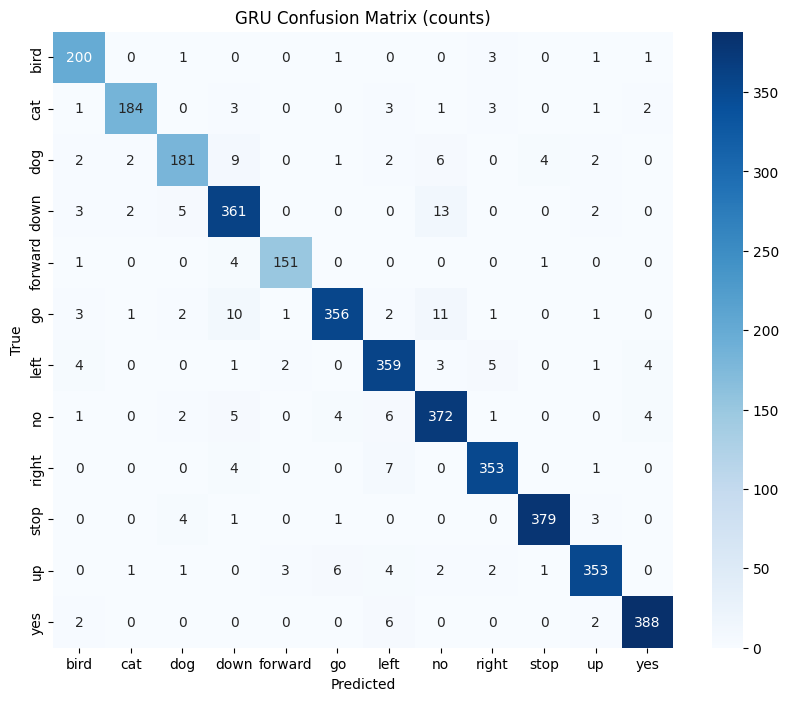

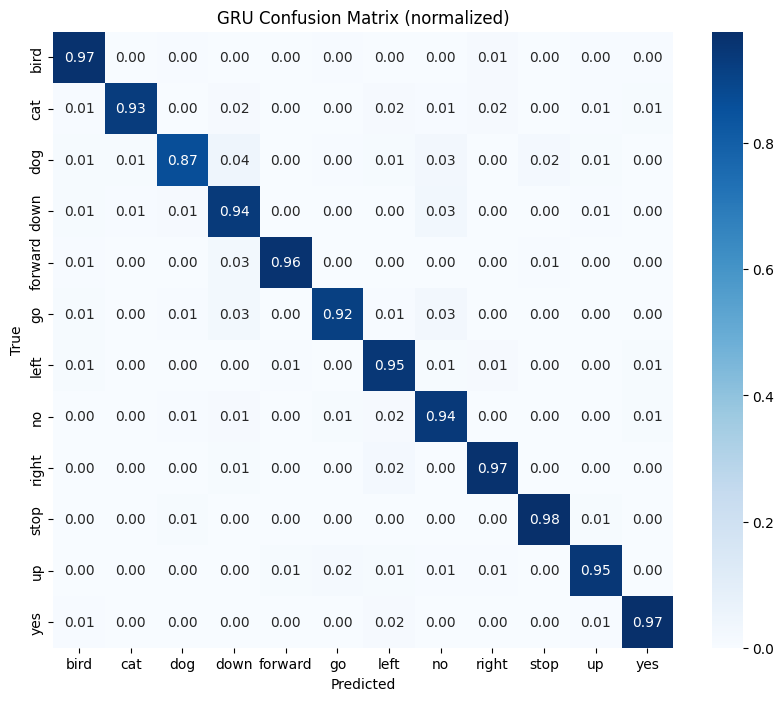

In [11]:

import os, torch, numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt, seaborn as sns

ck_path = "best_gru.pt"
# load checkpoint into existing model if needed
if os.path.exists(ck_path) and "model" in globals():
    ck = torch.load(ck_path, map_location="cpu")
    model.load_state_dict(ck["model_state"])

device = globals().get("device", "cpu")
model.to(device).eval()

y_true, y_pred = [], []
with torch.no_grad():
    for x,y in test_loader:
        x,y = x.to(device), y.to(device)
        preds = model(x).argmax(dim=1)
        y_true.append(y.cpu().numpy()); y_pred.append(preds.cpu().numpy())
y_true = np.concatenate(y_true); y_pred = np.concatenate(y_pred)

# labels in index order
if 'label2idx' in globals():
    labels = [None]*len(label2idx)
    for k,v in label2idx.items(): labels[v]=k
elif 'labels_unique' in globals():
    labels = labels_unique
else:
    labels = [str(i) for i in range(len(np.unique(y_true)))]

acc = (y_true == y_pred).mean()
print(f"Overall test acc: {acc:.6f}\n")
print(classification_report(y_true, y_pred, target_names=labels))

cm = confusion_matrix(y_true, y_pred)
cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)

plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title("GRU Confusion Matrix (counts)"); plt.xlabel("Predicted"); plt.ylabel("True"); plt.show()

plt.figure(figsize=(10,8))
sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title("GRU Confusion Matrix (normalized)"); plt.xlabel("Predicted"); plt.ylabel("True"); plt.show()

### <span style="color:orange">__GRU scatter (PCA of penultimate features)__</span>
- <span style="color:orange">__GRU/LSTM in this notebook expect time×frequency feature frames (mel spectrograms).__</span>
- <span style="color:orange">__PCA plot is of the model’s penultimate-layer embeddings produced after the mel spectrograms are passed through the network.__</span>


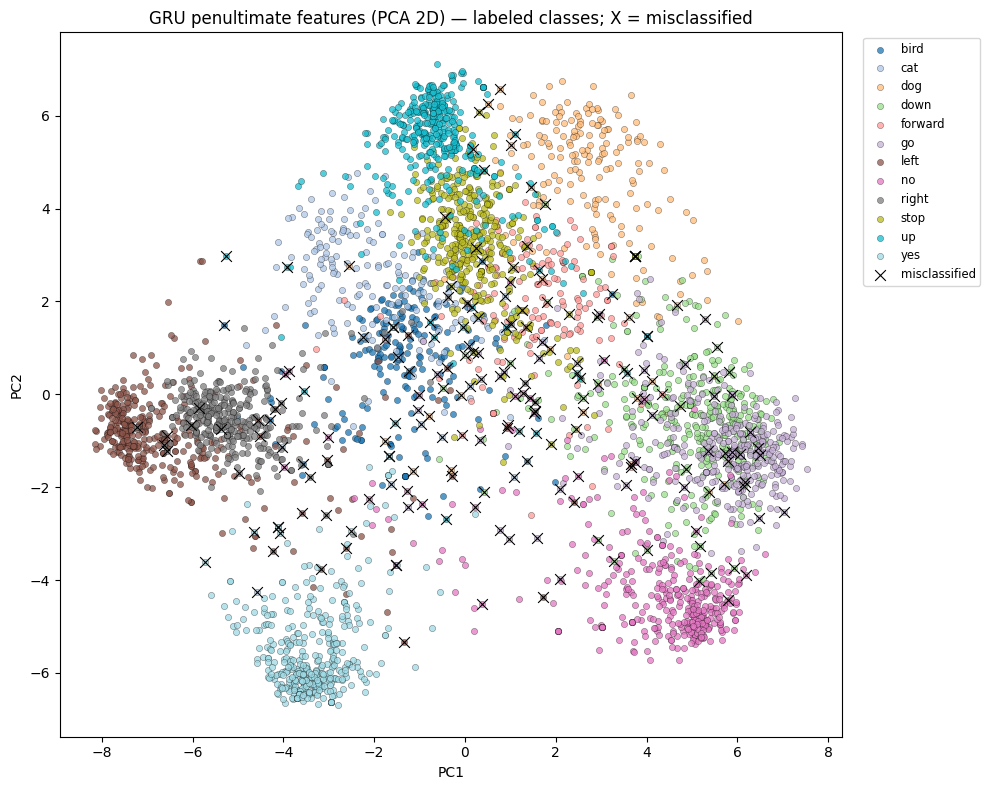

In [14]:
# collect penultimate features via hook
from sklearn.decomposition import PCA
from matplotlib import cm

feats, y_true, y_pred = [], [], []
hook = model.fc.register_forward_hook(lambda m, inp, out: feats.append(inp[0].detach().cpu().numpy()))

model.to(device).eval()
with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        out = model(x)
        preds = out.argmax(dim=1)
        y_true.append(y.cpu().numpy())
        y_pred.append(preds.cpu().numpy())

hook.remove()

# stack features and labels
X = np.vstack(feats)            # (N, hidden)
y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)

# labels (prefer label2idx if available)
if 'label2idx' in globals():
    labels = [None]*len(label2idx)
    for k,v in label2idx.items(): labels[v]=k
else:
    ncls = int(max(y_true.max(), y_pred.max()) + 1)
    labels = [str(i) for i in range(ncls)]

# PCA -> 2D
X2 = PCA(n_components=2).fit_transform(X)

plt.figure(figsize=(10,8))
cmap = cm.get_cmap('tab20', len(labels))

# plot classes: filled circles with thin black border
for idx, name in enumerate(labels):
    mask = (y_true == idx)
    if mask.sum() == 0: 
        continue
    plt.scatter(
        X2[mask,0], X2[mask,1],
        s=20,                       # marker size
        marker='o',
        color=cmap(idx),            # fill color
        edgecolors='k',             # thin black border
        linewidths=0.25,            # border thickness
        alpha=0.75,
        label=name,
        zorder=2
    )

# misclassified points: black X on top
wrong = (y_true != y_pred)
if wrong.any():
    plt.scatter(
        X2[wrong,0], X2[wrong,1],
        s=60, c='k', marker='x', linewidths=0.8, zorder=5, label='misclassified'
    )

plt.title("GRU penultimate features (PCA 2D) — labeled classes; X = misclassified")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.legend(bbox_to_anchor=(1.02,1), loc='upper left', fontsize='small')
plt.tight_layout()
plt.show()

### - <span style="color:orange">__GRU Scatter Plot (true vs predicted)__</span>

Total samples: 3843 Correct: 3637 Accuracy: 0.9463960447567005
Model: RNNClassifierGRU(
  (rnn): GRU(40, 128, num_layers=2, batch_first=True)
  (fc): Linear(in_features=128, out_features=12, bias=True)
)


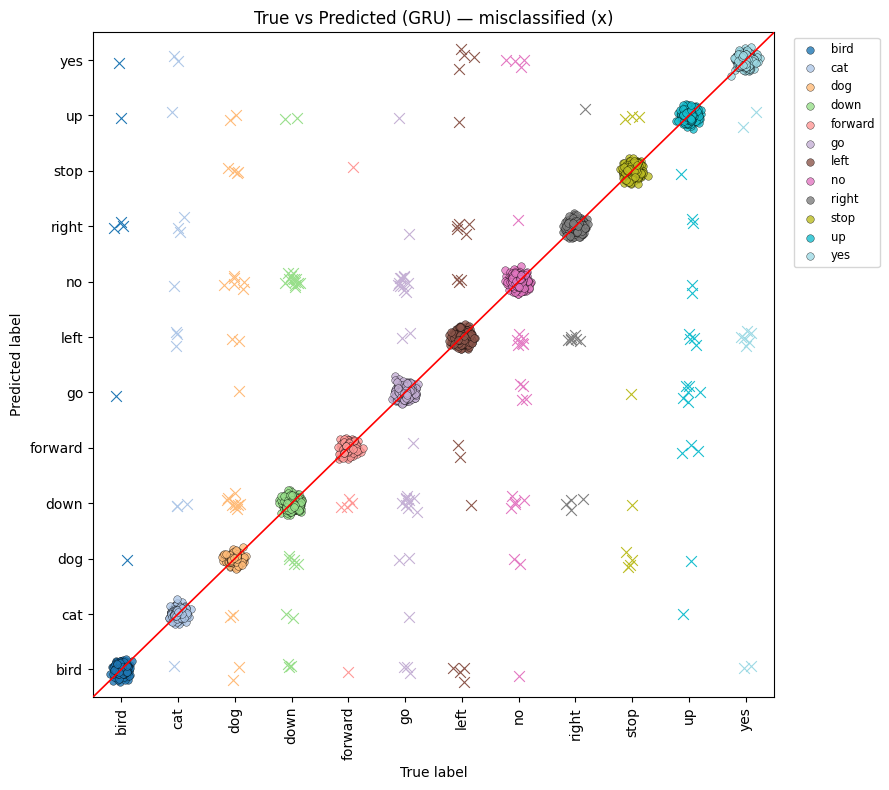

In [15]:

# collect preds
y_true_list, y_pred_list = [], []
model.to(device).eval()

with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        out = model(x)
        preds = out.argmax(dim=1)
        y_true_list.append(y.cpu().numpy())
        y_pred_list.append(preds.cpu().numpy())

# concatenate once
if len(y_true_list) == 0:
    raise RuntimeError("No test data found.")
y_true = np.concatenate(y_true_list)
y_pred = np.concatenate(y_pred_list)

# labels (build same way training did if available)
if 'label2idx' in globals():
    labels = [None] * len(label2idx)
    for k, v in label2idx.items():
        labels[v] = k
else:
    ncls = int(max(y_true.max(), y_pred.max()) + 1)
    labels = [str(i) for i in range(ncls)]

cmap = cm.get_cmap('tab20', len(labels))
plt.figure(figsize=(9,8))

# jitter to avoid heavy overlap
N = len(y_true)
jx = np.random.normal(scale=0.08, size=N)
jy = np.random.normal(scale=0.08, size=N)

# plot per class: correct = circles, misclassified = X
for i, name in enumerate(labels):
    mask_true = (y_true == i)
    if not mask_true.any():
        continue
    correct = mask_true & (y_pred == y_true)
    wrong = mask_true & (y_pred != y_true)
    if correct.any():
        plt.scatter(y_true[correct] + jx[correct],
                    y_pred[correct] + jy[correct],
                    s=30, marker='o', color=cmap(i),
                    alpha=0.8, edgecolors='k', linewidths=0.3, label=name)
    if wrong.any():
        plt.scatter(y_true[wrong] + jx[wrong],
                    y_pred[wrong] + jy[wrong],
                    s=60, marker='x', color=cmap(i),
                    edgecolors='k', linewidths=0.8, zorder=4)

# diagonal line and axes
lims = (-0.5, len(labels) - 0.5)
plt.plot(lims, lims, '-', color='red', linewidth=1.2, zorder=5)
plt.xlim(lims); plt.ylim(lims)
plt.xticks(range(len(labels)), labels, rotation=90)
plt.yticks(range(len(labels)), labels)
plt.xlabel("True label"); plt.ylabel("Predicted label")
plt.title("True vs Predicted (GRU) — misclassified (x)")
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', fontsize='small', ncol=1)
plt.tight_layout()

# confirm model and show
print("Total samples:", N, "Correct:", (y_true == y_pred).sum(), "Accuracy:", (y_true == y_pred).mean())
print("Model:", model)
plt.show()

### - <span style="color:orange">__Number audio files/label in each (train/val/test) split__</span>

In [ ]:
import os, collections
''' output directory (must match previous OUTDIR) '''
OUTDIR = "/Users/michaelevan/Universities/UMass/DeepLearning/Week_10/my_out_dir"

# count files per label per split   
cnt = collections.Counter()
for split in ("train","val","test"):
    d = os.path.join(OUTDIR, split, "clips")
    if not os.path.isdir(d): continue
    for fn in os.listdir(d):
        if not fn.lower().endswith((".wav",".mp3")): continue
        lbl = fn.split("__")[0]
        cnt[(lbl, split)] += 1

labels = sorted({k[0] for k in cnt})
for lbl in labels:
    print(f"{lbl:>7}: train = {cnt[(lbl,'train')]}  val = {cnt[(lbl,'val')]}  test = {cnt[(lbl,'test')]}")

   bird: train = 1641  val = 206  test = 207
    cat: train = 1624  val = 203  test = 198
    dog: train = 1702  val = 209  test = 209
   down: train = 3133  val = 391  test = 386
forward: train = 1237  val = 155  test = 157
     go: train = 3104  val = 384  test = 388
   left: train = 3040  val = 380  test = 379
     no: train = 3152  val = 377  test = 395
  right: train = 3022  val = 377  test = 365
   stop: train = 3059  val = 387  test = 388
     up: train = 2974  val = 371  test = 373
    yes: train = 3235  val = 401  test = 398


## - <span style="color:orange">__LSTM Model Training__</span>

Epoch 1/20 train_loss=2.1630 val_loss=2.1822 val_acc=19.66% time=44.9s
Saved best_lstm.pt (epoch 1, val_acc=19.66%)
Epoch 2/20 train_loss=1.8652 val_loss=1.5987 val_acc=43.69% time=44.6s
Saved best_lstm.pt (epoch 2, val_acc=43.69%)
Epoch 3/20 train_loss=1.4297 val_loss=1.1394 val_acc=59.39% time=47.0s
Saved best_lstm.pt (epoch 3, val_acc=59.39%)
Epoch 4/20 train_loss=1.0047 val_loss=0.8935 val_acc=68.16% time=45.9s
Saved best_lstm.pt (epoch 4, val_acc=68.16%)
Epoch 5/20 train_loss=0.7990 val_loss=0.7000 val_acc=76.88% time=47.0s
Saved best_lstm.pt (epoch 5, val_acc=76.88%)
Epoch 6/20 train_loss=0.6210 val_loss=0.5571 val_acc=81.91% time=46.8s
Saved best_lstm.pt (epoch 6, val_acc=81.91%)
Epoch 7/20 train_loss=0.5092 val_loss=0.4664 val_acc=85.03% time=47.2s
Saved best_lstm.pt (epoch 7, val_acc=85.03%)
Epoch 8/20 train_loss=0.4397 val_loss=0.4487 val_acc=85.60% time=46.8s
Saved best_lstm.pt (epoch 8, val_acc=85.60%)
Epoch 9/20 train_loss=0.3827 val_loss=0.3662 val_acc=88.26% time=46.6s
S

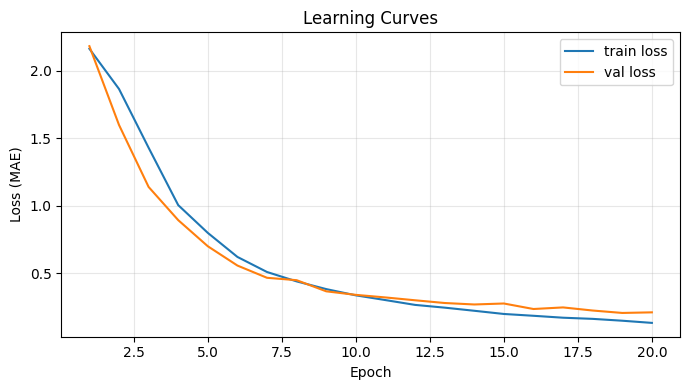

In [34]:
# LSTM training cell — matches GRU hyperparams
import time
import torch
import torch.nn as nn
import random

train_losses = []
val_losses = []

random.seed(42)
torch.manual_seed(42)

device = device  # reuse existing device variable from GRU cell

''' define LSTM model '''
class RNNClassifierLSTM(nn.Module):
    def __init__(self, input_size=40, hidden_size=128, num_layers=2, num_classes=None):
        super().__init__()
        self.rnn = nn.LSTM(input_size, hidden_size, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
    def forward(self, x):
        out, _ = self.rnn(x)                # out: (batch, seq, hidden)
        return self.fc(out[:, -1, :])       # last timestep

num_classes = len(labels)                   # reuse labels list
model_lstm = RNNClassifierLSTM(input_size=40, hidden_size=128, num_layers=2, num_classes=num_classes).to(device)    # move model to device
optimizer_lstm = torch.optim.Adam(model_lstm.parameters(), lr=1e-3) # Adam optimizer
loss_fn = nn.CrossEntropyLoss()                                     # cross-entropy loss

epochs = 20     # number of training epochs
best_val = -1.0 # best validation accuracy
patience = 10   # early stopping patience
no_improve = 0  # epochs since last improvement

''' training loop '''
for ep in range(1, epochs+1):
    t0 = time.time()                                # start time
    model_lstm.train()                              # set model to training mode
    running, seen = 0.0, 0                          # initialize running loss and seen samples
    for x,y in train_loader:                        # iterate over training data
        x = x.to(device); y = y.to(device).long()   # move data to device
        optimizer_lstm.zero_grad()                  # zero gradients
        out = model_lstm(x)                         # forward pass
        loss = loss_fn(out, y)                      # compute loss
        loss.backward()                             # backward pass
        optimizer_lstm.step()                       # update weights
        running += loss.item() * x.size(0)          # accumulate loss
        seen += x.size(0)                           # accumulate seen samples
    train_loss = running / max(1, seen)             # compute average training loss

    # validation (compute val_loss and val_acc)
    model_lstm.eval()                                               # set model to evaluation mode
    val_running, total, correct = 0.0, 0, 0                         # initialize validation metrics
    with torch.no_grad():                                           # disable gradient computation
        for x,y in val_loader:                                      # iterate over validation data
            x = x.to(device); y = y.to(device).long()               # move data to device
            out = model_lstm(x)                                     # forward pass
            loss_v = loss_fn(out, y)                                # compute loss
            val_running += loss_v.item() * x.size(0)                # accumulate validation loss
            preds = out.argmax(dim=1)                               # get predictions
            correct += (preds == y).sum().item()                    # count correct predictions
            total += y.size(0)                                      # accumulate total samples
    val_loss = val_running / max(1, total)                          # compute average validation loss
    val_acc = 100.0 * correct / total if total>0 else 0.0           # compute validation accuracy

    print(f"Epoch {ep}/{epochs} train_loss={train_loss:.4f} val_loss={val_loss:.4f} val_acc={val_acc:.2f}% time={time.time()-t0:.1f}s")

    ''' save best '''
    if val_acc > best_val:                                          # check for improvement
        best_val = val_acc                                          # update best validation accuracy
        no_improve = 0                                              # reset no improvement counter
        torch.save({
            "epoch": ep,
            "model_state": model_lstm.state_dict(),
            "optimizer_state": optimizer_lstm.state_dict(),
            "val_acc": val_acc,
            "labels": labels
        }, "best_lstm.pt")                                          # save checkpoint
        print(f"Saved best_lstm.pt (epoch {ep}, val_acc={val_acc:.2f}%)")
    else:
        no_improve += 1                                             # increment no improvement counter
        if patience and no_improve >= patience:                     # check for early stopping   
            print(f"No improvement for {patience} epochs — stopping at epoch {ep}")
            break

    train_losses.append(train_loss)                                 # append training loss
    val_losses.append(val_loss)                                     # append validation loss

# plot curves
plot_learning_curves(train_losses, val_losses, out="learning_curves.png", show=True)

### - <span style="color:orange">__LSTM final test accuracy__</span>


In [35]:
ck = torch.load("best_lstm.pt", map_location=device)    # or correct filename
model_lstm.load_state_dict(ck["model_state"])
model_lstm.to(device).eval()

correct, total = 0, 0
with torch.no_grad():
    for x,y in test_loader:
        x = x.to(device); y = y.to(device)
        preds = model_lstm(x).argmax(dim=1)
        correct += (preds == y).sum().item()
        total += y.size(0)

val = ck.get("val_acc", "?")
test_acc = 100.0 * correct / total if total > 0 else 0.0
val_str = f"{val:.2f}%" if isinstance(val, (int, float)) else val
print(f"Best val epoch {ck.get('epoch','?')} val_acc {val_str} Test acc {test_acc:.2f}%")

Best val epoch 20 val_acc 93.70% Test acc 92.82%


### - <span style="color:orange">__LSTM Confusion Matrix & Heat Map__</span>


Overall test acc: 0.928181

              precision    recall  f1-score   support

        bird       0.87      0.95      0.91       207
         cat       0.92      0.93      0.93       198
         dog       0.94      0.83      0.88       209
        down       0.88      0.89      0.88       386
     forward       0.89      0.96      0.92       157
          go       0.92      0.87      0.89       388
        left       0.93      0.91      0.92       379
          no       0.89      0.92      0.91       395
       right       0.97      0.96      0.97       365
        stop       0.96      0.96      0.96       388
          up       0.94      0.96      0.95       373
         yes       0.97      0.98      0.98       398

    accuracy                           0.93      3843
   macro avg       0.92      0.93      0.93      3843
weighted avg       0.93      0.93      0.93      3843

Confusion matrix shape: (12, 12)


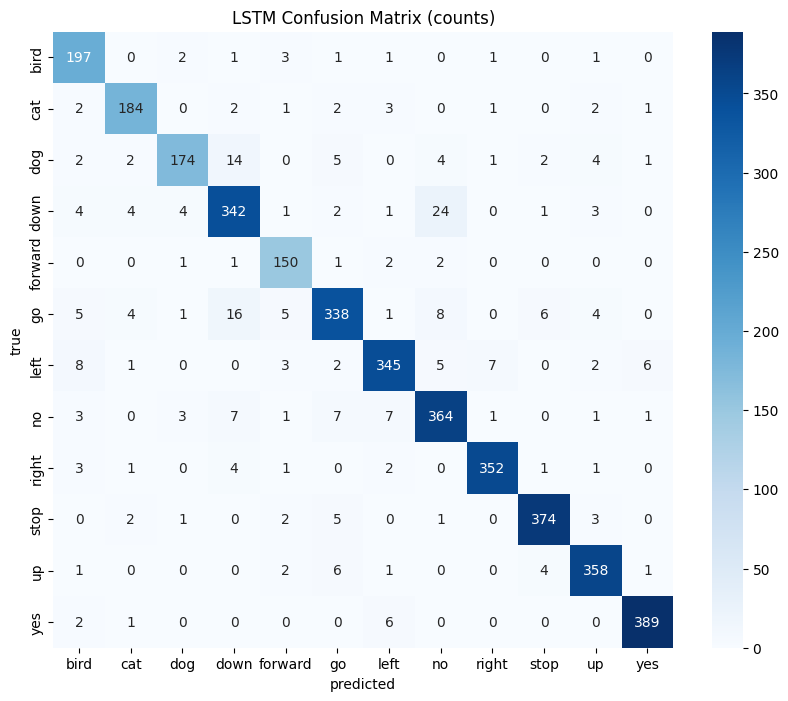

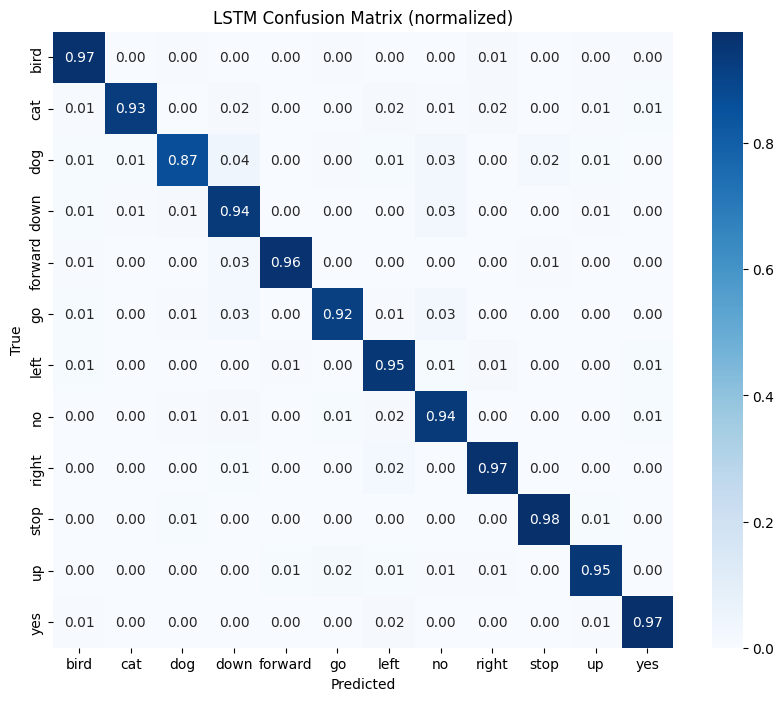

In [36]:
# Confusion matrix + classification report for LSTM
import os, torch, numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt, seaborn as sns

# load checkpoint if you have one
ck_path = "best_lstm.pt"
if os.path.exists(ck_path):
    ck = torch.load(ck_path, map_location=device)
    model_lstm.load_state_dict(ck["model_state"])

model_lstm.to(device).eval()

y_true, y_pred = [], []
with torch.no_grad():
    for x,y in test_loader:
        x,y = x.to(device), y.to(device)
        preds = model_lstm(x).argmax(dim=1)
        y_true.append(y.cpu().numpy())
        y_pred.append(preds.cpu().numpy())
y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)

# build label names in index order
if 'label2idx' in globals():
    labels = [None]*len(label2idx)
    for k,v in label2idx.items(): labels[v] = k
elif 'labels_unique' in globals():
    labels = labels_unique # type: ignore
elif 'labels' in globals():
    labels = labels
else:
    labels = [str(i) for i in range(len(np.unique(y_true)))]

acc = (y_true == y_pred).mean()
print(f"Overall test acc: {acc:.6f}\n")
print(classification_report(y_true, y_pred, target_names=labels))
cm = confusion_matrix(y_true, y_pred)
print("Confusion matrix shape:", cm.shape)

plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel("predicted"); plt.ylabel("true"); plt.title("LSTM Confusion Matrix (counts)")
plt.show()

plt.figure(figsize=(10,8))
sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title("LSTM Confusion Matrix (normalized)"); plt.xlabel("Predicted"); plt.ylabel("True"); plt.show()

### - <span style="color:orange">__LSTM scatter (PCA of penultimate features)__</span>



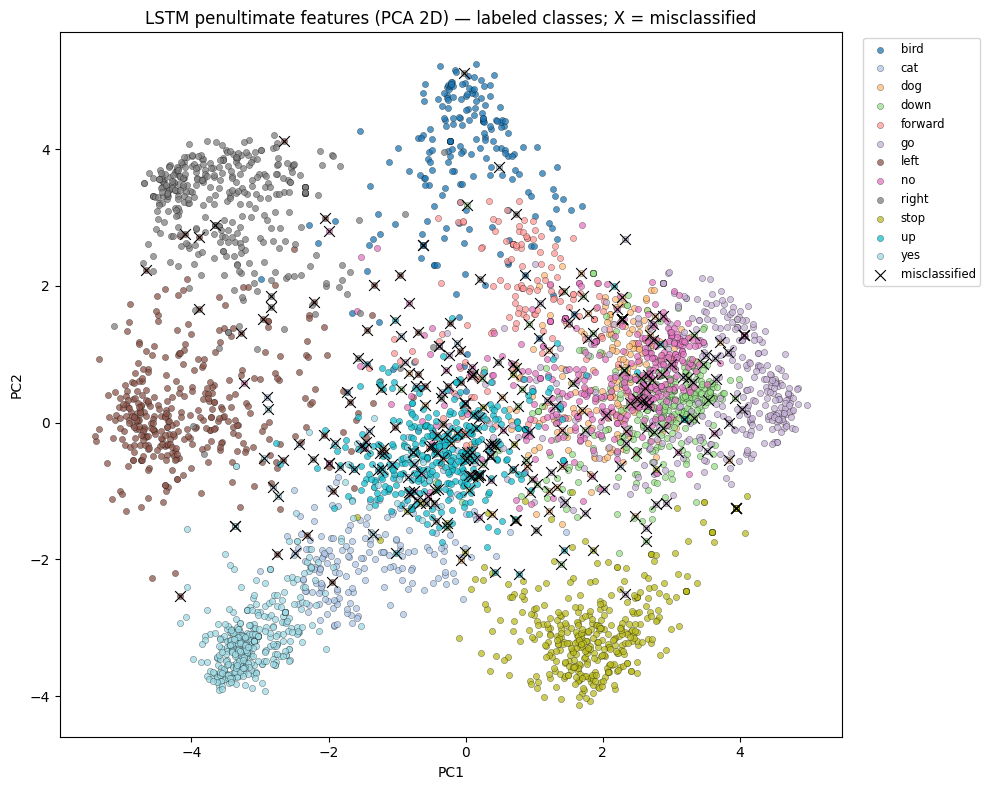

In [37]:
# collect penultimate features via hook
from sklearn.decomposition import PCA
from matplotlib import cm

feats, y_true, y_pred = [], [], []
hook = model_lstm.fc.register_forward_hook(lambda m, inp, out: feats.append(inp[0].detach().cpu().numpy()))

model_lstm.to(device).eval()
with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        out = model_lstm(x)
        preds = out.argmax(dim=1)
        y_true.append(y.cpu().numpy())
        y_pred.append(preds.cpu().numpy())

hook.remove()

# stack features and labels
X = np.vstack(feats)            # (N, hidden)
y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)

# labels (prefer label2idx if available)
if 'label2idx' in globals():
    labels = [None]*len(label2idx)
    for k,v in label2idx.items(): labels[v]=k
else:
    ncls = int(max(y_true.max(), y_pred.max()) + 1)
    labels = [str(i) for i in range(ncls)]

# PCA -> 2D
X2 = PCA(n_components=2).fit_transform(X)

plt.figure(figsize=(10,8))
cmap = cm.get_cmap('tab20', len(labels))

# plot classes: filled circles with thin black border
for idx, name in enumerate(labels):
    mask = (y_true == idx)
    if mask.sum() == 0: 
        continue
    plt.scatter(
        X2[mask,0], X2[mask,1],
        s=20,                       # marker size
        marker='o',
        color=cmap(idx),            # fill color
        edgecolors='k',             # thin black border
        linewidths=0.25,            # border thickness
        alpha=0.75,
        label=name,
        zorder=2
    )

# misclassified points: black X on top
wrong = (y_true != y_pred)
if wrong.any():
    plt.scatter(
        X2[wrong,0], X2[wrong,1],
        s=60, c='k', marker='x', linewidths=0.8, zorder=5, label='misclassified'
    )

plt.title("LSTM penultimate features (PCA 2D) — labeled classes; X = misclassified")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.legend(bbox_to_anchor=(1.02,1), loc='upper left', fontsize='small')
plt.tight_layout()
plt.show()

### - <span style="color:orange">__LSTM Scatter Plot (true vs predicted)__</span>

Total samples: 3843 Correct: 3567 Accuracy: 0.9281811085089774
Model: RNNClassifierLSTM(
  (rnn): LSTM(40, 128, num_layers=2, batch_first=True)
  (fc): Linear(in_features=128, out_features=12, bias=True)
)


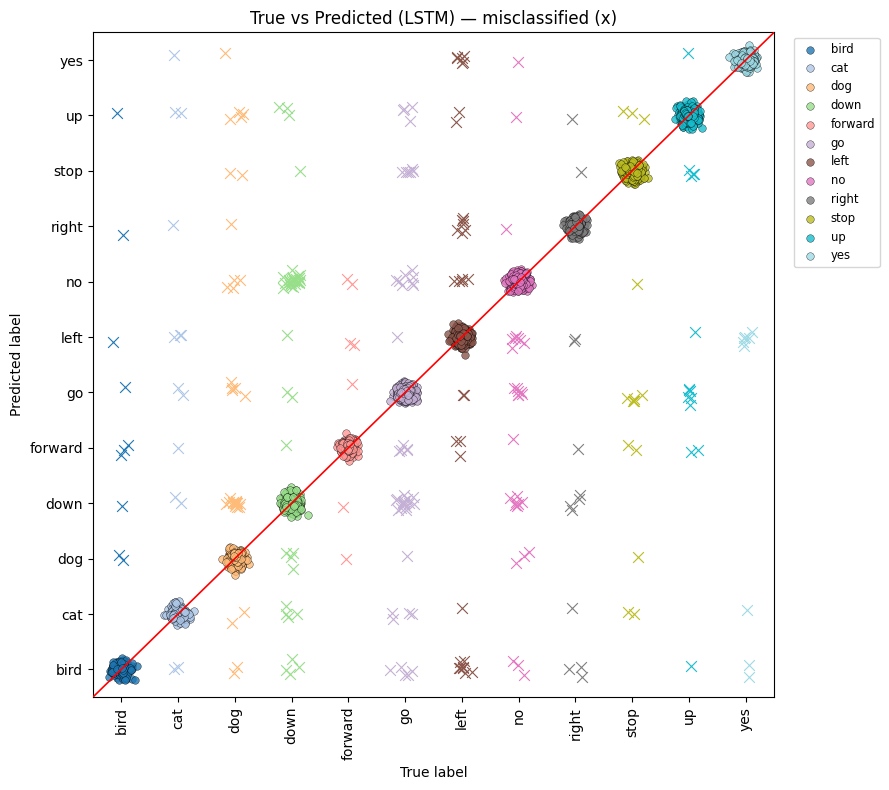


.........End of Notebook ..........


In [38]:

# collect preds
y_true_list, y_pred_list = [], []
model_lstm.to(device).eval()

with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        out = model_lstm(x)
        preds = out.argmax(dim=1)
        y_true_list.append(y.cpu().numpy())
        y_pred_list.append(preds.cpu().numpy())

# concatenate once
if len(y_true_list) == 0:
    raise RuntimeError("No test data found.")
y_true = np.concatenate(y_true_list)
y_pred = np.concatenate(y_pred_list)

# labels (build same way training did if available)
if 'label2idx' in globals():
    labels = [None] * len(label2idx)
    for k, v in label2idx.items():
        labels[v] = k
else:
    ncls = int(max(y_true.max(), y_pred.max()) + 1)
    labels = [str(i) for i in range(ncls)]

cmap = cm.get_cmap('tab20', len(labels))
plt.figure(figsize=(9,8))

# jitter to avoid heavy overlap
N = len(y_true)
jx = np.random.normal(scale=0.08, size=N)
jy = np.random.normal(scale=0.08, size=N)

# plot per class: correct = circles, misclassified = X
for i, name in enumerate(labels):
    mask_true = (y_true == i)
    if not mask_true.any():
        continue
    correct = mask_true & (y_pred == y_true)
    wrong = mask_true & (y_pred != y_true)
    if correct.any():
        plt.scatter(y_true[correct] + jx[correct],
                    y_pred[correct] + jy[correct],
                    s=30, marker='o', color=cmap(i),
                    alpha=0.8, edgecolors='k', linewidths=0.3, label=name)
    if wrong.any():
        plt.scatter(y_true[wrong] + jx[wrong],
                    y_pred[wrong] + jy[wrong],
                    s=60, marker='x', color=cmap(i),
                    edgecolors='k', linewidths=0.8, zorder=4)

# diagonal line and axes
lims = (-0.5, len(labels) - 0.5)
plt.plot(lims, lims, '-', color='red', linewidth=1.2, zorder=5)
plt.xlim(lims); plt.ylim(lims)
plt.xticks(range(len(labels)), labels, rotation=90)
plt.yticks(range(len(labels)), labels)
plt.xlabel("True label"); plt.ylabel("Predicted label")
plt.title("True vs Predicted (LSTM) — misclassified (x)")
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', fontsize='small', ncol=1)
plt.tight_layout()

# confirm model and show
print("Total samples:", N, "Correct:", (y_true == y_pred).sum(), "Accuracy:", (y_true == y_pred).mean())
print("Model:", model_lstm)
plt.show()
print()
print(".........End of Notebook ..........")